In [127]:
import pandas as pd
import csv
import numpy as np

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from torch.nn import functional


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import time
import math

SOS_token = 0
EOS_token = 1
PAD_token = 2
MAX_LENGTH = 200
teacher_forcing_ratio = 0.5
model_name = 'first_big_run'

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "<PAD>"}
        self.n_words = 3  # Count SOS and EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
                
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1            

def filterPair(p):
    return len(p[0]) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def getChars(item):
    return [element for element in item]

def get_data(file_range):
    print('File range:', list(file_range))
    data_list = []
    for i in file_range:
        index = str(i)
        if len(index) == 1:
            filename = 'output-0000{}-of-00100'.format(index)
        elif len(index) == 2:
            filename = 'output-000{}-of-00100'.format(index)
        else:
            raise ValueError('Wrong index')

        cur_data = pd.read_csv('../input/ru_with_types/' + filename, sep='\t', names=['class', 'before', 'after'],
                           quoting=csv.QUOTE_NONE, encoding='utf-8', dtype=str)

        if (cur_data.shape[0] > 1074563-10) and (cur_data.shape[0] < 1074563+10):
            print(filename)
        data_list.append(cur_data)
        print('Data shape for item {} is {}'.format(i,cur_data.shape))


    data_orig = pd.concat(data_list, axis=0)
    print('Overall data shape is {}'.format(data_orig.shape))
    
    return data_orig

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

def make_sample(data_learn, self_frac = 0.33, sil_frac = 1):

    data_nn = data_learn.copy()
    to_concat = []
    to_concat.append(data_nn[(data_nn.after != '<self>') & (data_nn.after != 'sil')])
    to_concat.append(data_nn[data_nn.after == '<self>'].sample(frac = self_frac))
    to_concat.append(data_nn[data_nn.after == 'sil'].sample(frac = sil_frac))

    data_nn = pd.concat(to_concat, axis=0)
    return data_nn

def get_pairs(data_orig, filter_length = MAX_LENGTH):

    big_str = list(data_orig.before.astype(str).values)
    output_list = list(data_orig.after.astype(str).values)
    types_list = list(data_orig['class'].values)
    
    stride = 3
    input_list = []
    pairs = []
    for i in range(len(big_str)):
        if big_str[i] != '<eos>':
            #print(big_str[i])
            cur_item = ['<norm>'] + getChars(big_str[i]) + ['</norm>']
            cur_type = types_list[i]
            cur_item = ['<{}>'.format(cur_type)] + cur_item + ['</{}>'.format(cur_type)]
            #print(big_str[i-stride:i])
            prefix = getChars(' '.join(big_str[i-stride:i]))
            #print(prefix)
            prefix = ' '.join(prefix).split('< e o s >')[-1].split(' ')
            #print(prefix)
            suffix = getChars(' '.join(big_str[i+1:i+stride+1]))
            suffix = ' '.join(suffix).split('< e o s >')[0].split(' ')
            cur_item = prefix \
            + cur_item + \
            suffix

            cur_item = ' '.join(cur_item)
            cur_item = cur_item.replace('  ', ' ')
            cur_item = cur_item.replace('  ', ' ')
            if cur_item[0] == ' ':
                cur_item = cur_item[1:]
            pairs += [(cur_item, output_list[i], cur_type)]

    #pairs = list(zip(input_list, output_list))
    print('Len of pairs:', len(pairs))
    
    if filter_length:
        pairs = filterPairs(pairs)
        print('Len of pairs after filtering:', len(pairs))
    return pairs

def trainIters_weighted(encoder, decoder, pairs, test_pairs, 
               n_iters, print_every=1000, plot_every=100, 
               learning_rate=0.01, evaluate_each=False):
    start = time.time()
    plot_losses = []
    plot_accuracies = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()
    
    classes = ['PLAIN', 'PUNCT', 'VERBATIM', 'ORDINAL', 'MEASURE', 'DATE',
           'ELECTRONIC', 'CARDINAL', 'LETTERS', 'DECIMAL', 'FRACTION',
           'TELEPHONE', 'TIME', 'MONEY', 'DIGIT', '<eos>']
    
    initial_weights = [3.0 for i in range(len(classes) -1)] + [0.0]
    initial_errors = [0.5 for i in range(len(classes) -1)] + [0.0]
    weight_dict = dict(zip(classes, initial_weights))
    weight_dict["PLAIN"] = 1
    weight_dict["PUNCT"] = 2
    
    error_dict = dict(zip(classes, initial_errors))
    cur_iter = 1
    epoch_lag = 20
    for big_iter in range(1, int(np.ceil(n_iters/evaluate_each))):
        even_sample = make_even_sample(pairs, size_of_class = 50)
        weighted_sample = sample_pairs(pairs, size = evaluate_each - len(even_sample) + 1,
                                       weight_dict = weight_dict)
        weighted_sample += even_sample
        print(weighted_sample[0])
        random.shuffle(weighted_sample)
        print(weighted_sample[0])
        print(len(weighted_sample))
        training_pairs = [variablesFromPair(item)
                      for item in weighted_sample]
        
        for iter in range(1, evaluate_each + 1):
            training_pair = training_pairs[iter - 1]
            input_variable = training_pair[0]
            target_variable = training_pair[1]

            loss = train(input_variable, target_variable, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if cur_iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, cur_iter / n_iters),
                                             cur_iter, cur_iter / n_iters * 100, print_loss_avg))
            cur_iter += 1

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

            if evaluate_each and iter % evaluate_each == 0 and iter != 0:

                cur_accuracy, new_error_dict = evaluate_pairs(encoder, decoder, test_pairs)
                for item in classes[:-1]:
                    if new_error_dict[item] >= error_dict[item]:
                        weight_dict[item] += 1
                    else:
                        error_dict[item] = new_error_dict[item]
                #error_dict = new_error_dict
                #weight_dict['<eos>'] = 0.0
                print(weight_dict)
                plot_accuracies.append(cur_accuracy)
            '''    
            if plot_losses and np.min(plot_losses) not in plot_losses[-epoch_lag:]:
                learning_rate = learning_rate/np.sqrt(10)
                epoch_lag += 5
                print('Setting new learning rate to {:.5f}'.format(learning_rate))
                encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
                decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
            ''' 

    #showPlot(plot_losses)
    #showPlot(plot_accuracies)
    
    return plot_losses

def sample_pairs(train_pairs, size = 1000, weight_dict = None):

    classes = ['PLAIN', 'PUNCT', 'VERBATIM', 'ORDINAL', 'MEASURE', 'DATE',
           'ELECTRONIC', 'CARDINAL', 'LETTERS', 'DECIMAL', 'FRACTION',
           'TELEPHONE', 'TIME', 'MONEY', 'DIGIT', '<eos>']
    
    if weight_dict is None:
        weights = [1 for i in range(len(classes) -1)] + [0.0]
        weight_dict = dict(zip(classes, weights))
        
        weight_dict['PLAIN'] = 0.05
        weight_dict['PUNCT'] = 0.15
        weight_dict['DECIMAL'] = 5
        weight_dict['FRACTION'] = 5
        weight_dict['MONEY'] = 20
        weight_dict['TIME'] = 10
        weight_dict['ELECTRONIC'] = 10
        weight_dict['ELECTRONIC'] = 10
        weight_dict['DIGIT'] = 10
        
        
    sample_weights = np.array([weight_dict[item[2]] for item in train_pairs])
    sample_weights = sample_weights/ sample_weights.sum()
    
    sample_indices = np.random.choice(range(len(train_pairs)), size = size, p=sample_weights)
    sample = [train_pairs[i] for i in sample_indices]
    
    return sample

def make_even_sample(pairs, size_of_class = 100):

    classes = ['PLAIN', 'PUNCT', 'VERBATIM', 'ORDINAL', 'MEASURE', 'DATE',
           'ELECTRONIC', 'CARDINAL', 'LETTERS', 'DECIMAL', 'FRACTION',
           'TELEPHONE', 'TIME', 'MONEY', 'DIGIT']
    
    sample = []
    for item in classes:
        class_pairs = [pair for pair in pairs if pair[2] == item]
        sample_indices = np.random.choice(range(len(class_pairs)), size = size_of_class)
        cur_sample = [class_pairs[i] for i in sample_indices]
        sample += cur_sample
        
    return sample

def evaluate_pairs(encoder, decoder, test_pairs):
    
    classes = ['PLAIN', 'PUNCT', 'VERBATIM', 'ORDINAL', 'MEASURE', 'DATE',
           'ELECTRONIC', 'CARDINAL', 'LETTERS', 'DECIMAL', 'FRACTION',
           'TELEPHONE', 'TIME', 'MONEY', 'DIGIT']
    
    results_dict = dict.fromkeys(classes)
    preds = np.array([(item[1], ' '.join(evaluate(encoder, decoder, item[0])[0][:-1]), item[0]) for item in test_pairs])
    results = np.array([item[0] == item[1] for item in preds])
    print('\t\t eval accuracy: {:.3f}'.format(results.mean()))

    for item in classes:
        results_dict[item] = 1 - np.mean([results[i] for i in range(len(results)) if test_pairs[i][2] == item])
        print('\t\t\t {} eval error: {:.3f}'.format(item, results_dict[item]))
    
    results_dict['<eos>'] = 0
    return results.mean(), results_dict

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#setting seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [141]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length)).cuda()

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = functional.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden
    
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.view(-1).dot(encoder_output.view(-1))
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output).view(-1)
            energy = hidden.view(-1).dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1)).view(-1)
            energy = self.v.view(-1).dot(energy)
            return energy
        
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [142]:
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

def random_batch(pairs, batch_size):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexesFromSentence(input_lang, pair[0]))
        target_seqs.append(indexesFromSentence(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

In [143]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(train_pairs, small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([67, 3])
target_batches torch.Size([5, 3])


In [144]:
USE_CUDA = torch.cuda.is_available()


small_hidden_size = 8
small_n_layers = 2

hidden_size = 256

encoder_test = EncoderRNN(input_lang.n_words, hidden_size, n_layers = 2)
decoder_test = LuongAttnDecoderRNN('general', hidden_size, output_lang.n_words,
                           n_layers = 2, dropout=0.2)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

In [145]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size())

encoder_outputs torch.Size([67, 3, 256])
encoder_hidden torch.Size([4, 3, 256])


In [146]:
decoder_input

Variable containing:
 2
 2
 3
[torch.cuda.LongTensor of size 3 (GPU 0)]

In [147]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths
)
print('loss', loss.data[0])

loss 7.937414646148682


/home/dpetrov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].
  """


In [148]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0], ec, dc

In [157]:

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [158]:
# Configure models
attn_model = 'dot'
hidden_size = 256
n_layers = 2
dropout = 0.1
batch_size = 100
batch_size = 50

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.01
decoder_learning_ratio = 5.0
n_epochs = 50000
epoch = 0
plot_every = 2
print_every = 2
evaluate_every = 1000

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [161]:
import socket
hostname = socket.gethostname()


# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(train_pairs, batch_size)
    
    print(len(input_batches))
    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    
    #job.record(epoch, loss)

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        #vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        #vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

75


/home/dpetrov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].
  """


70
2m 28s (- 20627m 8s) (6 0%) 10.4262
61
60
2m 51s (- 17845m 14s) (8 0%) 11.2056
79
68
3m 15s (- 16298m 14s) (10 0%) 11.6851
64
68
3m 36s (- 15034m 51s) (12 0%) 12.9327
59
78
3m 58s (- 14213m 29s) (14 0%) 9.6066
67
78
4m 19s (- 13521m 6s) (16 0%) 8.4035
61
59
4m 38s (- 12900m 50s) (18 0%) 7.7523
66
77
4m 55s (- 12326m 8s) (20 0%) 7.7323
68
58
5m 10s (- 11757m 15s) (22 0%) 5.4485
66
63
5m 25s (- 11311m 40s) (24 0%) 5.5261
73
66
6m 25s (- 12358m 27s) (26 0%) 9.6619
61
57
6m 38s (- 11863m 57s) (28 0%) 4.6885
65
52
7m 5s (- 11806m 19s) (30 0%) 9.6771
63
68
7m 22s (- 11516m 53s) (32 0%) 8.9777
67
72
7m 39s (- 11248m 6s) (34 0%) 4.9463
73
71
8m 0s (- 11117m 25s) (36 0%) 9.2044
64
56
8m 17s (- 10911m 40s) (38 0%) 8.3867
57
70
8m 35s (- 10740m 16s) (40 0%) 11.2259
75
62
8m 48s (- 10480m 49s) (42 0%) 4.7105
67
60
9m 11s (- 10431m 13s) (44 0%) 9.6441
65
68
9m 43s (- 10566m 38s) (46 0%) 9.6814
72
61
10m 2s (- 10445m 1s) (48 0%) 6.0985
64
54
10m 23s (- 10376m 43s) (50 0%) 9.7140
72
60
10m 42s (- 

KeyboardInterrupt: 

In [2]:
#%matplotlib inline

use_cuda = torch.cuda.is_available()

data_dev = get_data(range(0,2))
data_learn = get_data(range(5,8))

train_pairs = get_pairs(data_learn)
dev_pairs = get_pairs(data_dev)

input_lang, output_lang = Lang('nonnorm'), Lang('norm')

for pair in train_pairs + dev_pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
    
print(train_pairs[:5])
print(dev_pairs[:5])

File range: [0, 1]
Data shape for item 0 is (2973646, 3)
Data shape for item 1 is (2981069, 3)
Overall data shape is (5954715, 3)
File range: [5, 6, 7]
Data shape for item 5 is (2975471, 3)
Data shape for item 6 is (2980056, 3)
Data shape for item 7 is (2975255, 3)
Overall data shape is (8930782, 3)
Len of pairs: 8319218
Len of pairs after filtering: 8318115
Len of pairs: 5547039
Len of pairs after filtering: 5546221
[('<PLAIN> <norm> Д р у г а я </norm> </PLAIN> в е р с и я б е р е т н а ч а л о', '<self>', 'PLAIN'), ('<PLAIN> <norm> в е р с и я </norm> </PLAIN> б е р е т н а ч а л о о т', '<self>', 'PLAIN'), ('<PLAIN> <norm> б е р е т </norm> </PLAIN> н а ч а л о о т с л о в а', '<self>', 'PLAIN'), ('Д р у г а я в е р с и я б е р е т <PLAIN> <norm> н а ч а л о </norm> </PLAIN> о т с л о в а "', '<self>', 'PLAIN'), ('в е р с и я б е р е т н а ч а л о <PLAIN> <norm> о т </norm> </PLAIN> с л о в а " н е п е я', '<self>', 'PLAIN')]
[('<PLAIN> <norm> П о </norm> </PLAIN> с о с т о я н и ю

In [ ]:
torch.backends.cudnn.enabled = False
test_pairs = make_even_sample(dev_pairs, size_of_class = 300)

test_weight = dict((data_dev['class'].value_counts()/len(data_dev)))
print(test_weight)
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=4)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                           n_layers = 2, dropout_p=0.2)

if use_cuda:
    print('Using CUDA')
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

callback_num = 100

plot_losses = trainIters_weighted(encoder1, attn_decoder1, train_pairs, test_pairs, 1001, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=1000, learning_rate = 0.01)

torch.save(encoder1.state_dict() , 'models/encoder_{}.states'.format(model_name))
torch.save(attn_decoder1.state_dict(), 'models/decoder_{}.states'.format(model_name))


In [ ]:
acc, tst = evaluate_pairs(encoder1, attn_decoder1, test_pairs)

In [ ]:
encoder_load = EncoderRNN(input_lang.n_words, hidden_size, n_layers=4)
encoder_load.load_state_dict(torch.load('models/encoder_test.states'))

attn_decoder_load = AttnDecoderRNN(hidden_size, output_lang.n_words,
                           n_layers = 2, dropout_p=0.2)
attn_decoder_load.load_state_dict(torch.load('models/decoder_test.states'))

if use_cuda:
    print('Using CUDA')
    encoder1 = encoder_load.cuda()
    attn_decoder1 = attn_decoder_load.cuda()



In [ ]:
acc, acc1

In [ ]:
plot_losses = trainIters_weighted(encoder_load, attn_decoder_load, train_pairs, test_pairs, 1001, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=1000, learning_rate = 0.01)

In [27]:
def trainIters(encoder, decoder, pairs, test_pairs, 
               n_iters, print_every=1000, plot_every=100, 
               learning_rate=0.01, evaluate_each=False):
    start = time.time()
    plot_losses = []
    plot_accuracies = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    weighted_sample = sample_pairs(pairs, size = n_iters)
    training_pairs = [variablesFromPair(item)
                      for item in weighted_sample]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
 
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
        if evaluate_each and iter % evaluate_each == 0 and iter != 0:
            
            cur_accuracy, error_dict = evaluate_pairs(encoder, decoder, test_pairs)
            plot_accuracies.append(cur_accuracy)

    showPlot(plot_losses)
    showPlot(plot_accuracies)
    
    return plot_losses

In [29]:
test_weight = dict((data_train['class'].value_counts()/len(data_train)))
test_weight['<eos>'] = 0

In [ ]:
test_weight

{'<eos>': 0,
 'CARDINAL': 0.025764016055202905,
 'DATE': 0.017585580276203657,
 'DECIMAL': 0.00069005522333126165,
 'DIGIT': 0.00019026875556290237,
 'ELECTRONIC': 0.00055151460359982433,
 'FRACTION': 0.00023263476077770367,
 'LETTERS': 0.01792308981328318,
 'MEASURE': 0.0038331778021802607,
 'MONEY': 0.00025438516524065974,
 'ORDINAL': 0.0044198713208245177,
 'PLAIN': 0.69605445771702457,
 'PUNCT': 0.21642976378304218,
 'TELEPHONE': 0.00095399165314043687,
 'TIME': 0.00018393276817586733,
 'VERBATIM': 0.014933260302410059}

In [ ]:
torch.backends.cudnn.enabled = False
test_pairs = make_even_sample(dev_pairs, size_of_class = 300)


hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=4)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                           n_layers = 2, dropout_p=0.2)

if use_cuda:
    print('Using CUDA')
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

callback_num = 1000
plot_losses = trainIters_weighted(encoder1, attn_decoder1, train_pairs, test_pairs, 500000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=10000, learning_rate = 0.01)

Using CUDA
('э т о г о с т а л т р а н с п о р т н ы й <PLAIN> <norm> к о л л а п с </norm> </PLAIN> н а Л е н и н г р а д с к о м ш о с с е', '<self>', 'PLAIN')
('у с л о в и я х ( г о р о д <PLAIN> <norm> М е н з е л и н с к </norm> </PLAIN> ) п р о ж и в а ю т 5 9 , 1 1 %', '<self>', 'PLAIN')
10001
2m 4s (- 1039m 11s) (1000 0%) 1.8199
3m 59s (- 994m 13s) (2000 0%) 1.4111
5m 51s (- 970m 39s) (3000 0%) 1.4005
7m 42s (- 956m 1s) (4000 0%) 1.4486
9m 32s (- 944m 3s) (5000 1%) 1.3076
11m 23s (- 937m 27s) (6000 1%) 1.3273
13m 15s (- 933m 16s) (7000 1%) 1.1620
15m 6s (- 929m 39s) (8000 1%) 1.2938
16m 55s (- 923m 0s) (9000 1%) 1.1628
18m 49s (- 922m 6s) (10000 2%) 1.0666


In [51]:
torch.backends.cudnn.enabled = False
test_pairs = make_even_sample(dev_pairs, size_of_class = 300)


hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=4)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                           n_layers = 2, dropout_p=0.2)

if use_cuda:
    print('Using CUDA')
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

callback_num = 1000
plot_losses = trainIters_weighted(encoder1, attn_decoder1, train_pairs, test_pairs, 500000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=10000, learning_rate = 0.01)

Using CUDA
('с о с т о р о н ы м е с т н о г о <norm> н а с е л е н и я </norm> . ', '<self>', 'PLAIN')
('— п о м о ч ь с п р а в и т ь с я <norm> с о </norm> с в о и м и и н с т и н к т а м и .', '<self>', 'PLAIN')
10001
1m 49s (- 910m 30s) (1000 0%) 1.8550
3m 31s (- 876m 40s) (2000 0%) 1.4991
5m 14s (- 868m 23s) (3000 0%) 1.4103
6m 56s (- 859m 57s) (4000 0%) 1.4693
8m 36s (- 852m 55s) (5000 1%) 1.3569
10m 19s (- 850m 26s) (6000 1%) 1.2606
12m 2s (- 847m 57s) (7000 1%) 1.3307
13m 41s (- 841m 55s) (8000 1%) 1.3229
15m 23s (- 839m 35s) (9000 1%) 1.2368
17m 3s (- 836m 2s) (10000 2%) 1.1838
		 eval accuracy: 0.120
			 PLAIN eval error: 0.297
			 PUNCT eval error: 0.313
			 VERBATIM eval error: 0.633
			 ORDINAL eval error: 1.000
			 MEASURE eval error: 0.993
			 DATE eval error: 0.997
			 ELECTRONIC eval error: 0.993
			 CARDINAL eval error: 0.997
			 LETTERS eval error: 1.000
			 DECIMAL eval error: 0.983
			 FRACTION eval error: 0.997
			 TELEPHONE eval error: 1.000
			 TIME eval error:

133m 35s (- 878m 30s) (66000 13%) 0.5233
135m 20s (- 874m 39s) (67000 13%) 0.4685
137m 5s (- 870m 56s) (68000 13%) 0.5021
138m 52s (- 867m 26s) (69000 13%) 0.4670
140m 35s (- 863m 38s) (70000 14%) 0.4913
		 eval accuracy: 0.239
			 PLAIN eval error: 0.080
			 PUNCT eval error: 0.000
			 VERBATIM eval error: 0.080
			 ORDINAL eval error: 1.000
			 MEASURE eval error: 1.000
			 DATE eval error: 0.973
			 ELECTRONIC eval error: 0.980
			 CARDINAL eval error: 0.757
			 LETTERS eval error: 0.740
			 DECIMAL eval error: 0.983
			 FRACTION eval error: 1.000
			 TELEPHONE eval error: 1.000
			 TIME eval error: 1.000
			 MONEY eval error: 1.000
			 DIGIT eval error: 0.827
{'PLAIN': 4, 'PUNCT': 7, 'VERBATIM': 8.0, 'ORDINAL': 10.0, 'MEASURE': 10.0, 'DATE': 10.0, 'ELECTRONIC': 10.0, 'CARDINAL': 10.0, 'LETTERS': 10.0, 'DECIMAL': 10.0, 'FRACTION': 10.0, 'TELEPHONE': 10.0, 'TIME': 10.0, 'MONEY': 10.0, 'DIGIT': 10.0, '<eos>': 0.0}
('8 . П а ч у л и а <norm> В . П . </norm> В к р а ю З о л о т о г о', 

265m 54s (- 756m 49s) (130000 26%) 0.3100
		 eval accuracy: 0.354
			 PLAIN eval error: 0.067
			 PUNCT eval error: 0.000
			 VERBATIM eval error: 0.063
			 ORDINAL eval error: 0.853
			 MEASURE eval error: 0.897
			 DATE eval error: 0.727
			 ELECTRONIC eval error: 0.980
			 CARDINAL eval error: 0.550
			 LETTERS eval error: 0.393
			 DECIMAL eval error: 0.933
			 FRACTION eval error: 0.983
			 TELEPHONE eval error: 0.993
			 TIME eval error: 0.860
			 MONEY eval error: 1.000
			 DIGIT eval error: 0.387
{'PLAIN': 7, 'PUNCT': 13, 'VERBATIM': 11.0, 'ORDINAL': 16.0, 'MEASURE': 16.0, 'DATE': 16.0, 'ELECTRONIC': 16.0, 'CARDINAL': 16.0, 'LETTERS': 14.0, 'DECIMAL': 16.0, 'FRACTION': 16.0, 'TELEPHONE': 16.0, 'TIME': 16.0, 'MONEY': 16.0, 'DIGIT': 14.0, '<eos>': 0.0}
('<norm> К р о м е </norm> т о г о о н р а б о т а л', '<self>', 'PLAIN')
(', A n t o z z i C <norm> , </norm> e t a l .', 'sil', 'PUNCT')
10001
271m 14s (- 764m 3s) (131000 26%) 0.2585
273m 1s (- 761m 8s) (132000 26%) 0.2699
274m 

		 eval accuracy: 0.456
			 PLAIN eval error: 0.063
			 PUNCT eval error: 0.000
			 VERBATIM eval error: 0.043
			 ORDINAL eval error: 0.667
			 MEASURE eval error: 0.763
			 DATE eval error: 0.490
			 ELECTRONIC eval error: 0.980
			 CARDINAL eval error: 0.373
			 LETTERS eval error: 0.297
			 DECIMAL eval error: 0.857
			 FRACTION eval error: 0.947
			 TELEPHONE eval error: 0.997
			 TIME eval error: 0.520
			 MONEY eval error: 0.973
			 DIGIT eval error: 0.187
{'PLAIN': 13, 'PUNCT': 19, 'VERBATIM': 14.0, 'ORDINAL': 22.0, 'MEASURE': 22.0, 'DATE': 20.0, 'ELECTRONIC': 22.0, 'CARDINAL': 19.0, 'LETTERS': 16.0, 'DECIMAL': 22.0, 'FRACTION': 22.0, 'TELEPHONE': 22.0, 'TIME': 22.0, 'MONEY': 22.0, 'DIGIT': 17.0, '<eos>': 0.0}
('В 1 9 7 5 г о д у в <norm> д н е в н и к а х </norm> Б ы к о в а п о я в л я е т с я з а п и с ь', '<self>', 'PLAIN')
('в Д н е п р о п е т р о в с к и й г о с у д а р с т в е н н ы й <norm> У н и в е р с и т е т </norm> н а ф и з и к о -', '<self>', 'PLAIN')
10001
397m

517m 44s (- 521m 53s) (249000 49%) 0.1773
519m 29s (- 519m 29s) (250000 50%) 0.1632
		 eval accuracy: 0.473
			 PLAIN eval error: 0.060
			 PUNCT eval error: 0.000
			 VERBATIM eval error: 0.047
			 ORDINAL eval error: 0.640
			 MEASURE eval error: 0.717
			 DATE eval error: 0.467
			 ELECTRONIC eval error: 0.980
			 CARDINAL eval error: 0.343
			 LETTERS eval error: 0.277
			 DECIMAL eval error: 0.850
			 FRACTION eval error: 0.947
			 TELEPHONE eval error: 1.000
			 TIME eval error: 0.450
			 MONEY eval error: 0.960
			 DIGIT eval error: 0.163
{'PLAIN': 17, 'PUNCT': 25, 'VERBATIM': 20.0, 'ORDINAL': 28.0, 'MEASURE': 28.0, 'DATE': 24.0, 'ELECTRONIC': 28.0, 'CARDINAL': 23.0, 'LETTERS': 20.0, 'DECIMAL': 28.0, 'FRACTION': 28.0, 'TELEPHONE': 28.0, 'TIME': 23.0, 'MONEY': 28.0, 'DIGIT': 19.0, '<eos>': 0.0}
('П р е з и д и у м а б ы л Т и т о <norm> , </norm> з а н и м а в ш и й п о с т п о ж и з н е н н о г о', 'sil', 'PUNCT')
('в х о д и т в с о с т а в <norm> г о р о д с к о г о </norm> п 

			 DECIMAL eval error: 0.823
			 FRACTION eval error: 0.937
			 TELEPHONE eval error: 0.997
			 TIME eval error: 0.463
			 MONEY eval error: 0.943
			 DIGIT eval error: 0.177
{'PLAIN': 23, 'PUNCT': 31, 'VERBATIM': 26.0, 'ORDINAL': 34.0, 'MEASURE': 34.0, 'DATE': 29.0, 'ELECTRONIC': 34.0, 'CARDINAL': 28.0, 'LETTERS': 26.0, 'DECIMAL': 34.0, 'FRACTION': 34.0, 'TELEPHONE': 34.0, 'TIME': 27.0, 'MONEY': 34.0, 'DIGIT': 25.0, '<eos>': 0.0}
('н а р у с с к и й я з ы к <norm> н е т </norm> . ', '<self>', 'PLAIN')
('в е к а п р и х о д я т и <norm> д р у г и е </norm> и с с л е д о в а т е л и . ', '<self>', 'PLAIN')
10001
652m 28s (- 396m 31s) (311000 62%) 0.1414
654m 13s (- 394m 12s) (312000 62%) 0.1823
656m 0s (- 391m 55s) (313000 62%) 0.1662
657m 46s (- 389m 38s) (314000 62%) 0.1690
659m 32s (- 387m 21s) (315000 63%) 0.1555
661m 19s (- 385m 4s) (316000 63%) 0.1744
663m 6s (- 382m 48s) (317000 63%) 0.1796
664m 51s (- 380m 30s) (318000 63%) 0.1904
666m 38s (- 378m 15s) (319000 63%) 0.1715
668m 

('Н о с и т <norm> р а с к р а ш е н н ы й </norm> в х о л о д н ы е ц в е т а', '<self>', 'PLAIN')
('п р о г н а т ь д е р з к о г о к а в а л е р а <norm> , </norm> о д н а к о г о с т и п р и м и р я ю т', 'sil', 'PUNCT')
10001
780m 2s (- 271m 13s) (371000 74%) 0.1842
Setting new learning rate to 0.00000
781m 50s (- 269m 1s) (372000 74%) 0.1593
783m 36s (- 266m 48s) (373000 74%) 0.1644
785m 26s (- 264m 36s) (374000 74%) 0.2102
787m 13s (- 262m 24s) (375000 75%) 0.1899
789m 1s (- 260m 12s) (376000 75%) 0.1438
Setting new learning rate to 0.00000
790m 50s (- 258m 1s) (377000 75%) 0.1503
792m 38s (- 255m 49s) (378000 75%) 0.1458
794m 24s (- 253m 37s) (379000 75%) 0.1637
796m 12s (- 251m 26s) (380000 76%) 0.1910
		 eval accuracy: 0.474
			 PLAIN eval error: 0.060
			 PUNCT eval error: 0.000
			 VERBATIM eval error: 0.043
			 ORDINAL eval error: 0.637
			 MEASURE eval error: 0.713
			 DATE eval error: 0.473
			 ELECTRONIC eval error: 0.977
			 CARDINAL eval error: 0.340
			 LETTERS eval 

KeyboardInterrupt: 

In [54]:
torch.backends.cudnn.enabled = False
test_pairs = make_even_sample(dev_pairs, size_of_class = 300)


hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=4)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                           n_layers =2, dropout_p=0.1)

if use_cuda:
    print('Using CUDA')
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

callback_num = 1000
plot_losses = trainIters_weighted(encoder1, attn_decoder1, train_pairs, test_pairs, 100000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=5000, learning_rate = 0.01)

Using CUDA
1m 41s (- 166m 44s) (1000 1%) 1.6956
3m 12s (- 157m 30s) (2000 2%) 1.3795
4m 46s (- 154m 21s) (3000 3%) 1.4491
6m 19s (- 151m 51s) (4000 4%) 1.1839
7m 53s (- 149m 52s) (5000 5%) 1.1675
		 eval accuracy: 0.126
			 PLAIN eval error: 0.147
			 PUNCT eval error: 0.323
			 VERBATIM eval error: 0.703
			 ORDINAL eval error: 1.000
			 MEASURE eval error: 0.997
			 DATE eval error: 1.000
			 ELECTRONIC eval error: 0.990
			 CARDINAL eval error: 0.997
			 LETTERS eval error: 1.000
			 DECIMAL eval error: 0.987
			 FRACTION eval error: 0.990
			 TELEPHONE eval error: 1.000
			 TIME eval error: 0.983
			 MONEY eval error: 0.990
			 DIGIT eval error: 1.000
{'PLAIN': 1, 'PUNCT': 2, 'VERBATIM': 4.0, 'ORDINAL': 4.0, 'MEASURE': 4.0, 'DATE': 4.0, 'ELECTRONIC': 4.0, 'CARDINAL': 4.0, 'LETTERS': 4.0, 'DECIMAL': 4.0, 'FRACTION': 4.0, 'TELEPHONE': 4.0, 'TIME': 4.0, 'MONEY': 4.0, 'DIGIT': 4.0, '<eos>': 0.0}
12m 20s (- 193m 19s) (6000 6%) 1.3486
13m 53s (- 184m 30s) (7000 7%) 1.3110
15m 27s (- 177m

KeyboardInterrupt: 

In [55]:
plot_losses

NameError: name 'plot_losses' is not defined

In [ ]:
Using CUDA
1m 0s (- 49m 32s) (1000 2%) 1.3384
1m 56s (- 46m 37s) (2000 4%) 1.1094
2m 52s (- 44m 55s) (3000 6%) 0.9032
3m 47s (- 43m 32s) (4000 8%) 0.8677
4m 42s (- 42m 22s) (5000 10%) 0.8003
5m 38s (- 41m 21s) (6000 12%) 0.7245
6m 33s (- 40m 15s) (7000 14%) 0.7180
7m 28s (- 39m 16s) (8000 16%) 0.5546
8m 25s (- 38m 20s) (9000 18%) 0.5971
9m 21s (- 37m 24s) (10000 20%) 0.6258
		 eval accuracy: 0.831

10m 0s (- 991m 19s) (10000 1%) 0.0716
19m 7s (- 936m 56s) (20000 2%) 0.0660
28m 11s (- 911m 21s) (30000 3%) 0.0642
37m 15s (- 894m 2s) (40000 4%) 0.0750
46m 19s (- 880m 13s) (50000 5%) 0.0783
		 eval accuracy: 0.945
58m 57s (- 923m 37s) (60000 6%) 0.0748
68m 4s (- 904m 24s) (70000 7%) 0.0711
77m 7s (- 886m 55s) (80000 8%) 0.0685
86m 14s (- 872m 1s) (90000 9%) 0.0708
95m 18s (- 857m 49s) (100000 10%) 0.0752
		 eval accuracy: 0.946
107m 59s (- 873m 47s) (110000 11%) 0.0675
117m 6s (- 858m 49s) (120000 12%) 0.0722
126m 9s (- 844m 18s) (130000 13%) 0.0721
135m 16s (- 830m 57s) (140000 14%) 0.0749
144m 21s (- 818m 0s) (150000 15%) 0.0733
		 eval accuracy: 0.945
157m 3s (- 824m 33s) (160000 16%) 0.0709
166m 10s (- 811m 18s) (170000 17%) 0.0687
175m 13s (- 798m 14s) (180000 18%) 0.0720
184m 17s (- 785m 41s) (190000 19%) 0.0703
193m 24s (- 773m 38s) (200000 20%) 0.0763
		 eval accuracy: 0.945
206m 3s (- 775m 9s) (210000 21%) 0.0711
215m 7s (- 762m 43s) (220000 22%) 0.0733
224m 14s (- 750m 43s)

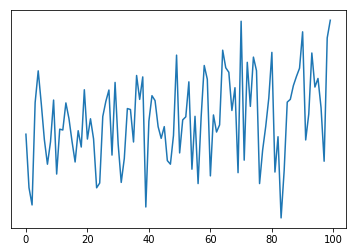

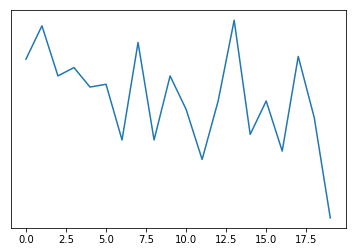

In [33]:
plot_losses = trainIters(encoder1, attn_decoder1, train_pairs, 1000000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=50000)

9m 33s (- 468m 22s) (10000 2%) 0.0770
18m 35s (- 446m 11s) (20000 4%) 0.0663
27m 39s (- 433m 24s) (30000 6%) 0.0677
36m 49s (- 423m 32s) (40000 8%) 0.0638
45m 53s (- 413m 5s) (50000 10%) 0.0647
		 eval accuracy: 0.947
58m 34s (- 429m 35s) (60000 12%) 0.0581
67m 38s (- 415m 30s) (70000 14%) 0.0609
76m 43s (- 402m 46s) (80000 16%) 0.0598
85m 47s (- 390m 51s) (90000 18%) 0.0645
94m 53s (- 379m 35s) (100000 20%) 0.0613
		 eval accuracy: 0.952
107m 34s (- 381m 24s) (110000 22%) 0.0596
116m 39s (- 369m 26s) (120000 24%) 0.0525
125m 45s (- 357m 55s) (130000 26%) 0.0580
134m 51s (- 346m 47s) (140000 28%) 0.0635
143m 56s (- 335m 50s) (150000 30%) 0.0581
		 eval accuracy: 0.953
156m 34s (- 332m 44s) (160000 32%) 0.0554
165m 36s (- 321m 29s) (170000 34%) 0.0523
174m 40s (- 310m 31s) (180000 36%) 0.0563
183m 42s (- 299m 43s) (190000 38%) 0.0583
192m 43s (- 289m 4s) (200000 40%) 0.0504
		 eval accuracy: 0.954
205m 16s (- 283m 28s) (210000 42%) 0.0534
214m 17s (- 272m 43s) (220000 44%) 0.0520
223m 2

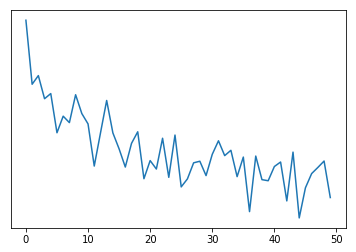

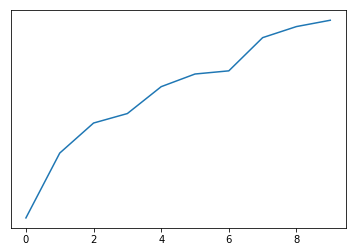

In [34]:
plot_losses = trainIters(encoder1, attn_decoder1, train_pairs, 500000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=50000, learning_rate = 0.001)

In [ ]:
plot_losses = trainIters(encoder1, attn_decoder1, train_pairs, 150000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=50000, learning_rate = 0.0001)

9m 12s (- 128m 51s) (10000 6%) 0.0526
18m 14s (- 118m 31s) (20000 13%) 0.0540
27m 14s (- 108m 56s) (30000 20%) 0.0541
36m 17s (- 99m 48s) (40000 26%) 0.0522
45m 21s (- 90m 43s) (50000 33%) 0.0481
		 eval accuracy: 0.960
57m 54s (- 86m 52s) (60000 40%) 0.0455
66m 56s (- 76m 30s) (70000 46%) 0.0468
75m 58s (- 66m 28s) (80000 53%) 0.0503
85m 1s (- 56m 41s) (90000 60%) 0.0515
94m 7s (- 47m 3s) (100000 66%) 0.0581
		 eval accuracy: 0.960


In [ ]:
ind_to_test = -51

print(input_list[ind_to_test])
evaluate(encoder1, attn_decoder1, input_list[ind_to_test])[0]

In [187]:
test_pairs = dev_pairs[-2000:]


preds = np.array([(item[1], ' '.join(evaluate(encoder1, attn_decoder1, item[0])[0][:-1]), item[0]) for item in test_pairs])

In [188]:
results = np.array([item[0] == item[1] for item in preds] )

In [189]:
results.mean()

0.61099999999999999

In [190]:
results_norm = np.array([item[0].lower() == item[1].lower() for item in preds] )
results_norm.mean()

0.61099999999999999

In [192]:
preds[~results][0]

array(['пятьдесят один', 'пятьсот одиннадцать',
       'и с т р е б и т е л и Р - <CARDINAL> 5 1 </CARDINAL> « М у с т а н г »'],
      dtype='<U141')

In [ ]:
ind_to_test = 5

print(input_list[ind_to_test])
evaluate(encoder1, attn_decoder1, input_list[ind_to_test])[0]

In [ ]:
input_list[0]